In [ ]:
from matplotlib import pyplot as plt

import numpy as np

for workload in [
    "oltpbench_tatp",
    # "oltpbench_tpcc",
    # "oltpbench_wikipedia",
    # "oltpbench_ycsb",
    "sbread",
    "sbrw",
    "sbwrite",
    "twitter",
]:
    current_similarity = []
    previous_similarity = []
    with open(f"/root/OpAdviserPrivate/logs/DBTune-{workload}_smac.log") as f:
        for containing in f:
            split = containing.split("similarity:")
            if len(split) > 1:
                if workload in split[0].split()[-1]:
                    current_similarity.append(float(split[1].split()[0]))
                else:
                    previous_similarity.append(float(split[1].split()[0]))
    plt.plot(
        np.linspace(0, 10, len(previous_similarity)),
        previous_similarity,
        label="previous",
    )
    plt.plot(
        np.linspace(0, 10, len(current_similarity)), current_similarity, label="current"
    )
    plt.legend()
    plt.title(f"{workload}")
    plt.show()

/tmp/ipykernel_1715276/2355886733.py:138: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(1 / np.array(current_similarity), color="r")


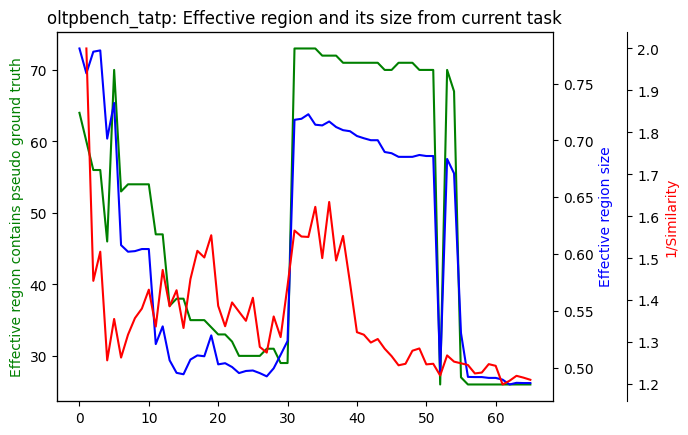

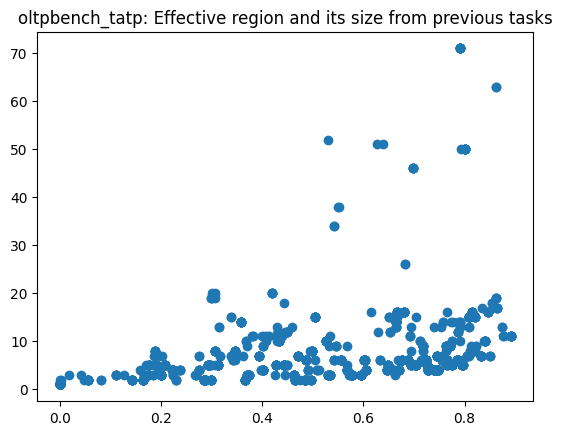

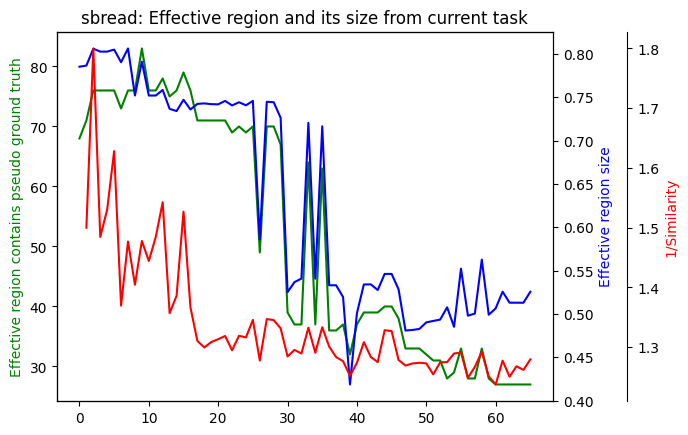

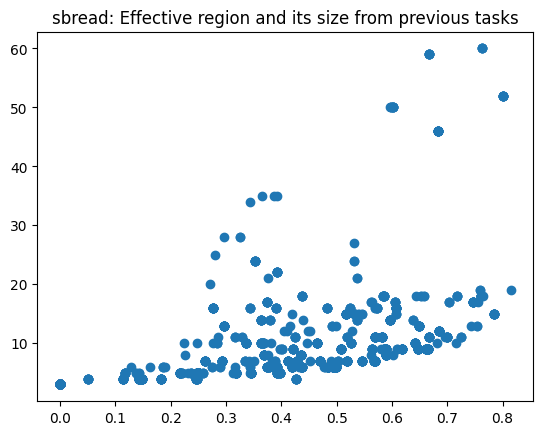

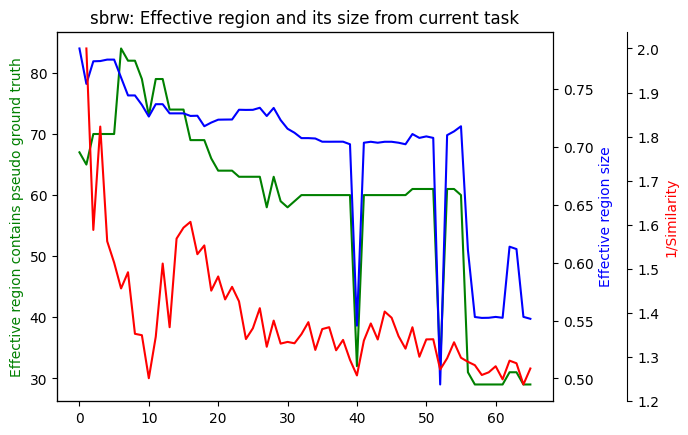

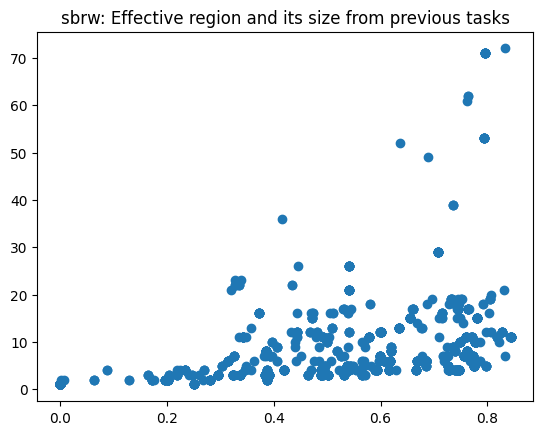

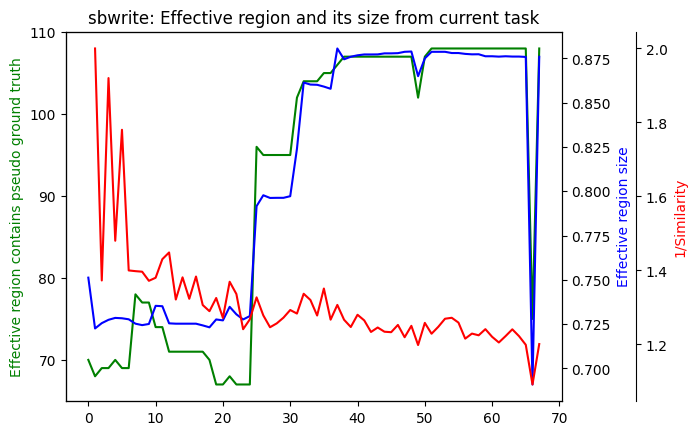

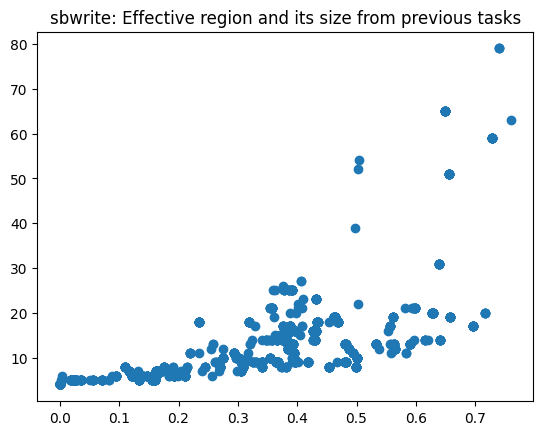

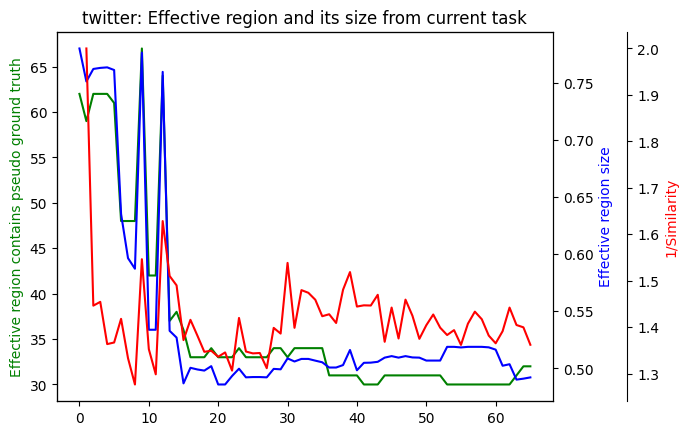

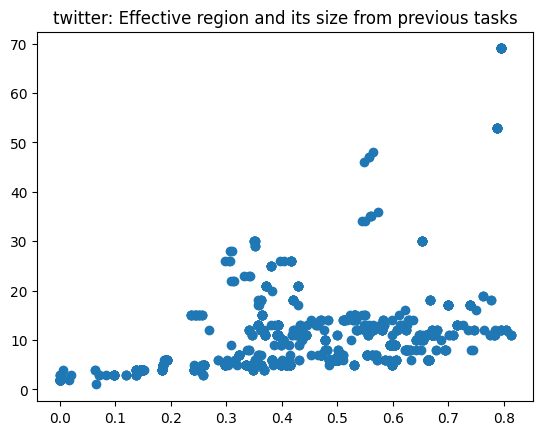

In [ ]:
import json
import sys

from matplotlib import pyplot as plt
import numpy as np
from autotune.utils.config_space import (
    ConfigurationSpace,
    UniformIntegerHyperparameter,
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
)


def initialize_knobs(knobs_config, num):
    global KNOBS
    global KNOB_DETAILS
    if num == -1:
        f = open(knobs_config)
        KNOB_DETAILS = json.load(f)
        KNOBS = list(KNOB_DETAILS.keys())
        f.close()
    else:
        f = open(knobs_config)
        knob_tmp = json.load(f)
        i = 0
        KNOB_DETAILS = {}
        while i < num:
            key = list(knob_tmp.keys())[i]
            KNOB_DETAILS[key] = knob_tmp[key]
            i = i + 1
        KNOBS = list(KNOB_DETAILS.keys())
        f.close()
    return KNOB_DETAILS


knob_config_file = (
    "/workspaces/OpAdviserPrivate/scripts/experiment/gen_knobs/mysql_all_197_32G.json"
)
knob_num = 197
KNOBS = initialize_knobs(knob_config_file, knob_num)
knobs_list = []
config_space = ConfigurationSpace()

for name in KNOBS.keys():
    value = KNOBS[name]
    knob_type = value["type"]
    if knob_type == "enum":
        knob = CategoricalHyperparameter(
            name,
            [str(i) for i in value["enum_values"]],
            default_value=str(value["default"]),
        )
    elif knob_type == "integer":
        min_val, max_val = value["min"], value["max"]
        if KNOBS[name]["max"] > sys.maxsize:
            knob = UniformIntegerHyperparameter(
                name,
                int(min_val / 1000),
                int(max_val / 1000),
                default_value=int(value["default"] / 1000),
            )
        else:
            knob = UniformIntegerHyperparameter(
                name, min_val, max_val, default_value=value["default"]
            )
    elif knob_type == "float" or knob_type == "real":
        min_val, max_val = value["min"], value["max"]
        knob = UniformFloatHyperparameter(
            name, min_val, max_val, default_value=value["default"]
        )
    else:
        raise ValueError("Invalid knob type!")

    knobs_list.append(knob)

config_space.add_hyperparameters(knobs_list)

for workload in [
    "oltpbench_tatp",
    # "oltpbench_tpcc",
    # "oltpbench_wikipedia",
    # "oltpbench_ycsb",
    "sbread",
    "sbrw",
    "sbwrite",
    "twitter",
]:
    with open(
        f"/workspaces/OpAdviserPrivate/repo/history_{workload}_smac_ground_truth.json"
    ) as f:
        j = json.load(f)["data"]
        c = sorted(j, key=lambda x: x["external_metrics"].get("tps", 0))[-1]
    with open(f"/workspaces/OpAdviserPrivate/logs/DBTune-{workload}_smac.log") as f:
        currents = []
        previouses = []
        current_sizes = []
        previous_sizes = []

        current_similarity = []
        for containing in f:
            split = containing.split(f"[DBTune-{workload}_smac]")
            if len(split) > 1:
                if "similarity:" in split[1]:
                    ss = split[1]
                    if workload in ss:
                        current_similarity.append(
                            float(split[1].split("similarity:")[1].split()[0])
                        )
                    pass
                try:
                    j = eval(split[1].replace("'", '"'))
                    count = 0
                    size = []
                    for knob in j:
                        p = config_space.get_hyperparameters_dict()[knob]
                        if isinstance(p, CategoricalHyperparameter):
                            continue
                        transform = p._transform
                        if transform(j[knob][0]) <= c["configuration"][knob] and c[
                            "configuration"
                        ][knob] <= transform(j[knob][1]):
                            count += 1
                            size.append(j[knob][1] - j[knob][0])
                    if workload in ss:
                        currents.append(count)
                        current_sizes.append(sum(size) / len(size))
                    else:
                        previouses.append(count)
                        previous_sizes.append(sum(size) / len(size))
                except:
                    continue
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax2.plot(current_sizes, color="b")
        ax2.set_ylabel("Effective region size", color="b")
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("axes", 1.15))  # Offset the third axis
        ax3.plot(1 / np.(current_similarity), color="r")
        ax3.set_ylabel("1/Similarity", color="r")
        ax1.plot(currents, color="g")
        ax1.set_ylabel("Effective region contains pseudo ground truth", color="g")
        # plt.legend()
        plt.title(f"{workload}: Effective region and its size from current task")
        plt.show()
        plt.scatter(previous_sizes, previouses)
        # fig, ax1 = plt.subplots(figsize=(20, 6))
        # fig
        # ax2 = ax1.twinx()
        # ax2.plot(previous_sizes, color="b")
        # ax2.set_ylabel("Effective region size", color="b")
        # ax1.plot(previouses, color="g")
        # ax1.set_ylabel("Effective region contains pseudo ground truth", color="g")
        # plt.legend()
        plt.title(f"{workload}: Effective region and its size from previous tasks")
        plt.show()

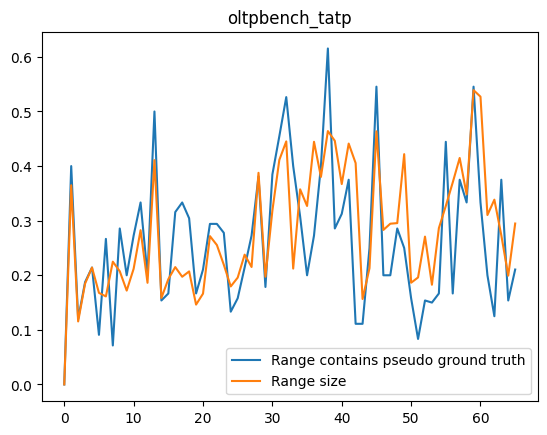

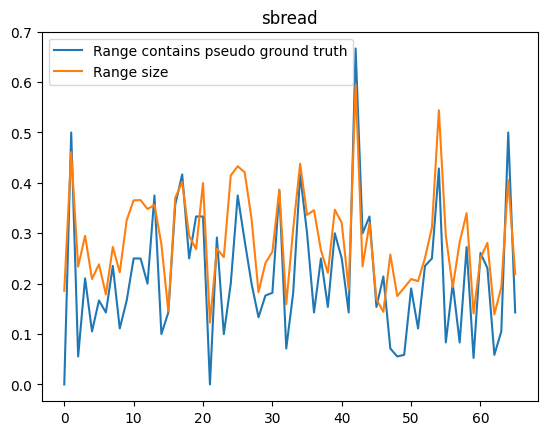

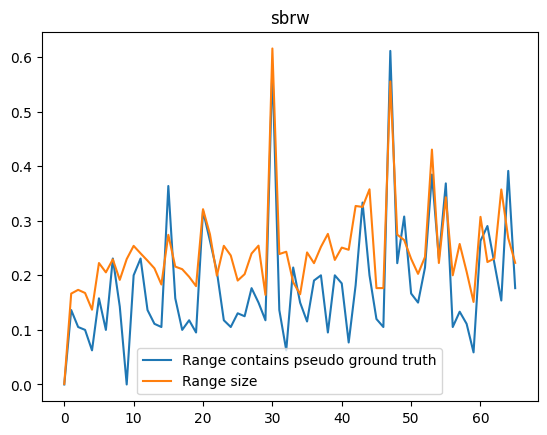

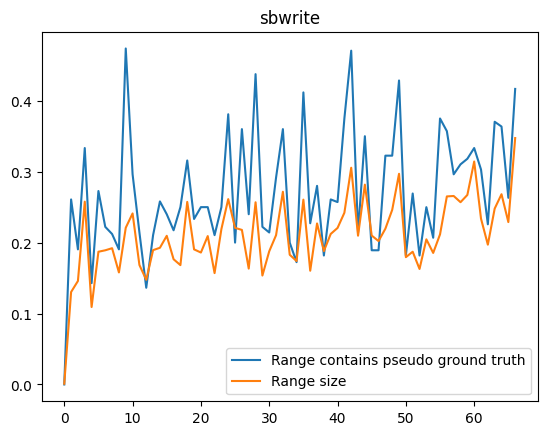

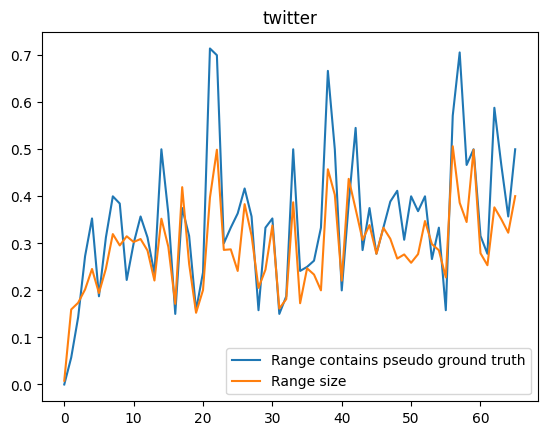

In [ ]:
import pprint
import re
from typing import List


class Hyperparameter:
    def __init__(
        self, name: str, param_type: str, param_range: List[int], default: int
    ):
        self.name = name
        self.param_type = param_type
        self.param_range = param_range
        self.default = default

    def __repr__(self) -> str:
        return (
            f"Hyperparameter(name='{self.name}', type='{self.param_type}', "
            f"range={self.param_range}, default={self.default})"
        )


CONFIG_BLOCK_PATTERN = re.compile(
    r"Configuration space object:\s*"
    r"Hyperparameters:(.*?)(?=Configuration space object:|$)",
    re.DOTALL,  # Enables matching across multiple lines
)
HYPERPARAMETER_PATTERN = re.compile(
    r"\s*(\w+), Type: (\w+), Range: \[(\d+), (\d+)\], Default: (\d+)"
)
for workload in [
    "oltpbench_tatp",
    # "oltpbench_tpcc",
    # "oltpbench_wikipedia",
    # "oltpbench_ycsb",
    "sbread",
    "sbrw",
    "sbwrite",
    "twitter",
]:
    with open(
        f"/workspaces/OpAdviserPrivate/repo/history_{workload}_smac_ground_truth.json"
    ) as f:
        j = json.load(f)["data"]
        c = sorted(j, key=lambda x: x["external_metrics"].get("tps", 0))[-1]
        # pprint.pprint((c["configuration"], c["external_metrics"]))
    c = c["configuration"]
    with open(
        f"/workspaces/OpAdviserPrivate/scripts/experiment/gen_knobs/mysql_all_197_32G.json"
    ) as f:
        j = json.load(f)
    with open(f"/workspaces/OpAdviserPrivate/logs/DBTune-{workload}_smac.log") as f:
        config_text = f.read()
        config_blocks = CONFIG_BLOCK_PATTERN.findall(config_text)
        contains = []
        sizes = []
        for block in config_blocks:
            hyperparameters = []
            containing = []
            size = []
            for match in HYPERPARAMETER_PATTERN.findall(block):
                name, param_type, range_start, range_end, default = match
                if param_type != "UniformInteger":
                    pprint.pprint(param_type)
                if int(range_start) <= c[name] <= int(range_end):
                    containing.append(1)
                else:
                    containing.append(0)
                hyperparameters.append(
                    Hyperparameter(
                        name=name,
                        param_type=param_type,
                        param_range=[int(range_start), int(range_end)],
                        default=int(default),
                    )
                )
                size.append(
                    (int(range_end) - int(range_start))
                    / (j[name]["max"] - j[name]["min"])
                )
            contains.append(sum(containing) / len(containing))
            sizes.append(sum(size) / len(size))
        plt.plot(contains, label="Range contains pseudo ground truth")
        plt.plot(sizes, label="Range size")
        plt.title(workload)
        plt.legend()
        plt.show()

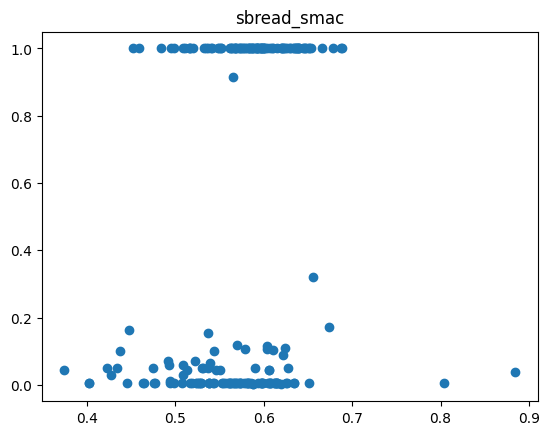

In [ ]:
workload = "sbread_smac"
similarity_list = [0.610725, 0.56105, 0.61915, 0.53745, 0.45175, 0.6062000000000001, 0.5399, 0.52885, 0.522575, 0.56715, 0.6267, 0.60635, 0.6507000000000001, 0.619875, 0.5986, 0.5983, 0.570525, 0.585425, 0.606525, 0.6402, 0.526475, 0.561225, 0.6129, 0.4979, 0.57275, 0.50875, 0.6369750000000001, 0.57865, 0.6472249999999999, 0.5678000000000001, 0.5878749999999999, 0.493525, 0.5372, 0.531525, 0.5619000000000001, 0.644625, 0.5203, 0.475125, 0.5069250000000001, 0.5862499999999999, 0.607425, 0.508875, 0.530525, 0.6516, 0.528825, 0.5324249999999999, 0.63365, 0.592975, 0.8845, 0.57655, 0.5441, 0.563625, 0.514775, 0.5929249999999999, 0.5512, 0.597575, 0.46409999999999996, 0.49822500000000003, 0.538225, 0.577875, 0.5492250000000001, 0.653, 0.5803499999999999, 0.569125, 0.6462749999999999, 0.5952500000000001, 0.6144000000000001, 0.5363, 0.5412250000000001, 0.54535, 0.551625, 0.56845, 0.402525, 0.5824, 0.6877, 0.58355, 0.603525, 0.402675, 0.56465, 0.5966750000000001, 0.5892999999999999, 0.603525, 0.5937, 0.5928, 0.638625, 0.45872500000000005, 0.62995, 0.37412500000000004, 0.5999749999999999, 0.47597500000000004, 0.5589, 0.609575, 0.67355, 0.62435, 0.59675, 0.607275, 0.42757500000000004, 0.573025, 0.4942, 0.6788000000000001, 0.6265499999999999, 0.512625, 0.51695, 0.552225, 0.645825, 0.5991, 0.62785, 0.665875, 0.6009249999999999, 0.491575, 0.60305, 0.43755, 0.42245, 0.43365, 0.634675, 0.566825, 0.5367999999999999, 0.624, 0.59685, 0.4636, 0.574325, 0.539175, 0.6107750000000001, 0.55, 0.5085, 0.57675, 0.599825, 0.61435, 0.543025, 0.622525, 0.583125, 0.5342, 0.639825, 0.63895, 0.5103249999999999, 0.57455, 0.48362499999999997, 0.58675, 0.56975, 0.634625, 0.6140749999999999, 0.585575, 0.5877749999999999, 0.608275, 0.5533, 0.6131, 0.5727, 0.5809, 0.5655, 0.6211, 0.516, 0.566975, 0.5260750000000001, 0.494425, 0.5846750000000001, 0.6150249999999999, 0.5379499999999999, 0.63725, 0.49234999999999995, 0.6369750000000001, 0.58985, 0.624925, 0.573075, 0.543525, 0.5986, 0.5227999999999999, 0.5965, 0.605925, 0.611075, 0.633375, 0.58195, 0.447075, 0.566125, 0.5560499999999999, 0.57985, 0.6214999999999999, 0.56175, 0.6212500000000001, 0.6557999999999999, 0.592025, 0.58175, 0.6145499999999999, 0.5787249999999999, 0.688475, 0.5633250000000001, 0.561825, 0.477175, 0.6507000000000001, 0.5238499999999999, 0.6211, 0.5973999999999999, 0.44477500000000003, 0.5187999999999999, 0.516575, 0.5687, 0.5715, 0.604625, 0.5969249999999999, 0.583075, 0.5484249999999999, 0.59065, 0.587675, 0.6353500000000001, 0.62995, 0.564125, 0.591275, 0.8037]
ranks = [0.1044776119402985, 0.004975124378109453, 0.003105590062111801, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0013020833333333333, 0.010638297872340425, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.029850746268656716, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.03980099502487562, 1.0, 0.09950248756218906, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.11940298507462686, 1.0, 1.0, 1.0, 0.15422885572139303, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.11442786069651742, 0.004975124378109453, 0.9152542372881356, 0.004975124378109453, 1.0, 0.1065989847715736, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.17069486404833836, 0.10945273631840796, 1.0, 0.004975124378109453, 0.029850746268656716, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.04477611940298507, 1.0, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 1.0, 1.0, 0.06965174129353234, 1.0, 0.09950248756218906, 0.04975124378109453, 0.04975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.06467661691542288, 1.0, 0.04477611940298507, 0.05970149253731343, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.05970149253731343, 1.0, 0.04950495049504951, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.16417910447761194, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.08955223880597014, 1.0, 1.0, 0.3215077605321508, 1.0, 0.004975124378109453, 0.004975124378109453, 0.1065989847715736, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.0014184397163120568, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

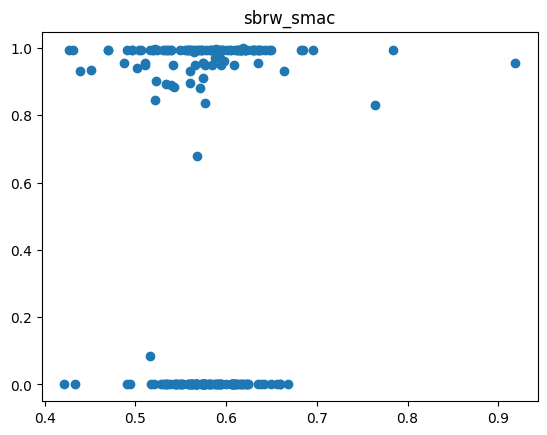

In [ ]:
workload = "sbrw_smac"
similarity_list = [0.560775, 0.53915, 0.5217, 0.5822499999999999, 0.538025, 0.575125, 0.5582, 0.5496, 0.56065, 0.631325, 0.56575, 0.575125, 0.567625, 0.594075, 0.5194, 0.618125, 0.5867249999999999, 0.5847249999999999, 0.5244249999999999, 0.5727249999999999, 0.582775, 0.56705, 0.47030000000000005, 0.6058, 0.535675, 0.610825, 0.6594, 0.6065, 0.621675, 0.56145, 0.58945, 0.565075, 0.542125, 0.53915, 0.5656, 0.5437000000000001, 0.533925, 0.5660499999999999, 0.5199750000000001, 0.607675, 0.6113, 0.5882000000000001, 0.541925, 0.573875, 0.58525, 0.592125, 0.63525, 0.5206999999999999, 0.597825, 0.550575, 0.522825, 0.573575, 0.5799000000000001, 0.5890500000000001, 0.592475, 0.5605, 0.595825, 0.494225, 0.62815, 0.6305000000000001, 0.5445249999999999, 0.638825, 0.589175, 0.570975, 0.6496500000000001, 0.5609999999999999, 0.52815, 0.5221750000000001, 0.5752999999999999, 0.6152, 0.560025, 0.581475, 0.491375, 0.609575, 0.574925, 0.682075, 0.54245, 0.42684999999999995, 0.5164, 0.43142499999999995, 0.5624, 0.53345, 0.64325, 0.563875, 0.606325, 0.5827, 0.575125, 0.487575, 0.6069, 0.496375, 0.918575, 0.551725, 0.76435, 0.53885, 0.529975, 0.470375, 0.59365, 0.491225, 0.6127750000000001, 0.610125, 0.62355, 0.51025, 0.6168750000000001, 0.62105, 0.6128, 0.576675, 0.510775, 0.623875, 0.5499499999999999, 0.663825, 0.55995, 0.616975, 0.576775, 0.584425, 0.5615, 0.532225, 0.59485, 0.557975, 0.655925, 0.53295, 0.6091, 0.45162500000000005, 0.552075, 0.635275, 0.43947499999999995, 0.5684, 0.5461750000000001, 0.593175, 0.5626, 0.561925, 0.535325, 0.5657, 0.42169999999999996, 0.57405, 0.60895, 0.6293, 0.6218250000000001, 0.5348999999999999, 0.5963499999999999, 0.6171, 0.638, 0.5173749999999999, 0.5668, 0.55785, 0.556675, 0.593925, 0.5896250000000001, 0.62095, 0.5057499999999999, 0.5765, 0.5829, 0.594425, 0.5351, 0.43405000000000005, 0.5461750000000001, 0.603925, 0.6172500000000001, 0.6051, 0.5022249999999999, 0.6594, 0.6083000000000001, 0.5734, 0.5304, 0.5684, 0.5939749999999999, 0.5581, 0.5166, 0.6844250000000001, 0.570125, 0.64215, 0.623775, 0.5764, 0.5913999999999999, 0.5552, 0.616475, 0.5744, 0.573975, 0.582275, 0.5680499999999999, 0.568325, 0.6953, 0.496675, 0.6005750000000001, 0.600325, 0.634825, 0.504425, 0.6211249999999999, 0.567625, 0.571025, 0.5765, 0.6476, 0.6492, 0.5776, 0.6129, 0.612575, 0.6360250000000001, 0.6159250000000001, 0.5757749999999999, 0.63515, 0.615675, 0.54975, 0.619175, 0.59165, 0.575125, 0.6683749999999999, 0.6073500000000001, 0.7844]
ranks = [0.8955223880597015, 0.9950248756218906, 0.9968944099378882, 0.9950248756218906, 0.0, 0.9552238805970149, 0.0, 0.9950248756218906, 0.9303482587064676, 0.9950248756218906, 0.0, 0.9552238805970149, 0.0, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9982935153583617, 0.9893617021276596, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.9502487562189055, 0.9950248756218906, 0.0, 0.0, 0.9701492537313433, 0.9502487562189055, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.0, 0.9601990049751243, 0.0, 0.900497512437811, 0.0, 0.0, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.0, 0.8805970149253731, 0.0, 0.0, 0.0, 0.845771144278607, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.8855721393034826, 0.9950248756218906, 0.0847457627118644, 0.9950248756218906, 0.0, 0.8934010152284264, 0.9950248756218906, 0.0, 0.0, 0.0, 0.0, 0.9552238805970149, 0.0, 0.9950248756218906, 0.9552238805970149, 0.0, 0.8293051359516617, 0.8905472636815921, 0.0, 0.9950248756218906, 0.9701492537313433, 0.0, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9552238805970149, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9502487562189055, 0.0, 0.0, 0.9303482587064676, 0.0, 0.9950248756218906, 0.9502487562189055, 0.9502487562189055, 0.9950248756218906, 0.0, 0.9502487562189055, 0.0, 0.0, 0.9950248756218906, 0.0, 0.9353233830845771, 0.0, 0.9552238805970149, 0.9310344827586207, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9950248756218906, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.0, 0.9950248756218906, 0.0, 0.0, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9402985074626866, 0.0, 0.9504950495049505, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.835820895522388, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9104477611940298, 0.0, 0.0, 0.6784922394678492, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9949238578680203, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.9950248756218906, 0.0, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.0, 0.0, 0.0, 0.0, 0.9985815602836879, 0.0, 0.0, 0.0, 0.0, 0.9950248756218906]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

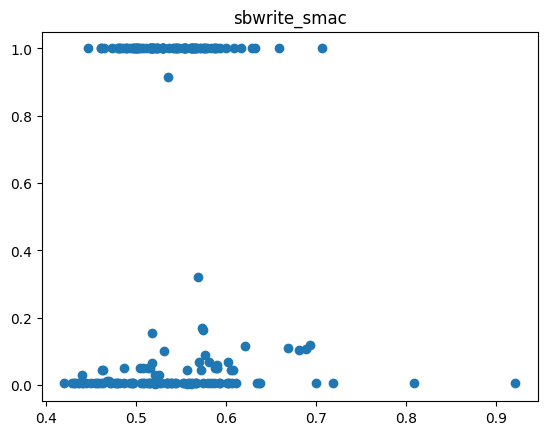

In [ ]:
workload = "sbwrite_smac"
similarity_list = [0.6817900547016162, 0.471399222791515, 0.5214227370609639, 0.6381030172520482, 0.5231553674414, 0.6056285735501596, 0.563946436969382, 0.5221900448008713, 0.5705799361401945, 0.4413009578970818, 0.46461721244523646, 0.60763347441895, 0.5225613227395361, 0.508130986856761, 0.6024355832776416, 0.5710254696665924, 0.48530976956015937, 0.6346130046285983, 0.49573030370535387, 0.5020667805252346, 0.5342937056013465, 0.5004579094576866, 0.5594663498428256, 0.5259770797752531, 0.4966213707581496, 0.5294423405361253, 0.5018935174871909, 0.5307294373901636, 0.5304324150392317, 0.5426598351525953, 0.5616445137496597, 0.4685527585950843, 0.5178832207123586, 0.5905546892403654, 0.6365931536348111, 0.7067894359050518, 0.4820672755624861, 0.5130566075097152, 0.5663968713645702, 0.4968441375213485, 0.5781787579515358, 0.5208286923591, 0.59050518551521, 0.5054577856983737, 0.6033018984678598, 0.5941189574515482, 0.5350115096160986, 0.561768273062548, 0.5445904804336527, 0.5417687680997996, 0.5312739783668721, 0.564664240984134, 0.48899779708423063, 0.588475532783842, 0.5302096482760328, 0.5579069825004331, 0.5095170911611099, 0.566273112051682, 0.5808024553847677, 0.43169723521695, 0.5301106408257221, 0.5628326031533872, 0.5551100220291577, 0.6938194599143586, 0.5613227395361501, 0.48996311972475926, 0.4968441375213485, 0.5186010247271107, 0.5836736714437761, 0.5720650478948541, 0.5191950694289745, 0.5538229251751194, 0.5634513997178288, 0.5345164723645455, 0.5119180218311428, 0.4504343951882379, 0.6219400509888369, 0.5161258384693448, 0.5355560505928071, 0.5930793792232866, 0.553129873022945, 0.6896363951387342, 0.4355337739164872, 0.5184525135516447, 0.5364471176456028, 0.4940966807752283, 0.48080493057102547, 0.4626865671641791, 0.5680304942946957, 0.4568698794584293, 0.586520135640207, 0.4988737902527165, 0.5740699487636445, 0.6689190861612336, 0.6589440855424371, 0.5375361995990198, 0.4402366278062424, 0.632088314645677, 0.6016435236751565, 0.5653077894111531, 0.5665701344026137, 0.4639489121556397, 0.5448627509220069, 0.42899928219598527, 0.5238979233187298, 0.588475532783842, 0.5043192000198016, 0.5156060493552139, 0.5169674017969852, 0.6025840944531076, 0.629192346724091, 0.514442711814064, 0.48709190366575084, 0.5159030717061459, 0.543253879854459, 0.4736021385609267, 0.5883765253335314, 0.5631791292294746, 0.4892205638474295, 0.497388678498057, 0.5871389322046484, 0.5184277616890671, 0.5475359520803941, 0.5571644266231034, 0.4707804262270736, 0.5185515210019553, 0.5528576025345907, 0.47912180391574466, 0.5834261528179996, 0.5156555530803693, 0.5721888072077423, 0.5289225514219945, 0.5455805549367589, 0.5795153585307294, 0.5155565456300586, 0.46377564911759606, 0.5547634959530705, 0.608871067547833, 0.5394173411549219, 0.5623128140392565, 0.45422143016261973, 0.4821910348753744, 0.5447884953342739, 0.46154798148560683, 0.5923615752085345, 0.5081804905819163, 0.5303581594514988, 0.5125120665330066, 0.5537486695873864, 0.5195663473676394, 0.5556545630058662, 0.5672136828296329, 0.5527833469468577, 0.5908269597287196, 0.5759758421821242, 0.4580579688621569, 0.4322170243310809, 0.49813123437538676, 0.5899853964010792, 0.5018935174871909, 0.9217098586668647, 0.4764981064825128, 0.4205341451944259, 0.5260265835004084, 0.4999876240687112, 0.5075616940174748, 0.7196356525828569, 0.4719685156308012, 0.4866216182767753, 0.5059775748125046, 0.524467216158016, 0.5748125046409742, 0.437439667334967, 0.6114205093933318, 0.4452365040469295, 0.5764461275710997, 0.5761491052201678, 0.46174599638622804, 0.5694413504616223, 0.6004306824088512, 0.48129996782257867, 0.5162495977822331, 0.7006014702606371, 0.5612979876735724, 0.44033563525655306, 0.479097052053167, 0.5277592138808445, 0.5225613227395361, 0.5406549342838048, 0.5195663473676394, 0.493180861859855, 0.581718274300141, 0.5204821662830128, 0.5669909160664339, 0.6068909185416203, 0.5748620083661296, 0.5614960025741937, 0.617509467587436, 0.5460508403257345, 0.4614984777604515, 0.5040716813940249, 0.5565703819212395, 0.44687012697705497, 0.48080493057102547, 0.5763223682582115, 0.5546644885027598, 0.8091631395262493]
ranks = [0.1044776119402985, 0.004975124378109453, 0.003105590062111801, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.029850746268656716, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0017064846416382253, 0.010638297872340425, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.029850746268656716, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.09950248756218906, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.11940298507462686, 1.0, 1.0, 1.0, 0.15422885572139303, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.11442786069651742, 0.004975124378109453, 0.9152542372881356, 0.004975124378109453, 1.0, 0.1065989847715736, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.17069486404833836, 0.10945273631840796, 1.0, 0.004975124378109453, 0.029850746268656716, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.04477611940298507, 1.0, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 1.0, 1.0, 0.06965174129353234, 1.0, 0.004975124378109453, 0.04975124378109453, 0.04975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.06467661691542288, 1.0, 0.04477611940298507, 0.011494252873563218, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.05970149253731343, 1.0, 0.0049504950495049506, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.16417910447761194, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.08955223880597014, 1.0, 1.0, 0.3215077605321508, 1.0, 0.004975124378109453, 0.004975124378109453, 0.005076142131979695, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.0014184397163120568, 1.0, 1.0, 1.0, 1.0, 0.0049504950495049506]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

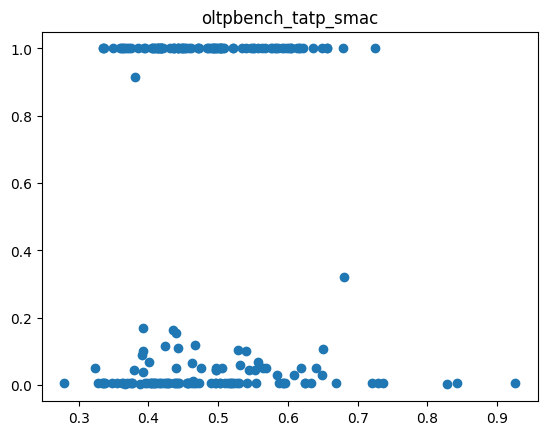

In [ ]:
workload = "oltpbench_tatp_smac"
similarity_list = [0.528525, 0.36950000000000005, 0.366475, 0.4446, 0.39397499999999996, 0.497, 0.434925, 0.348225, 0.40059999999999996, 0.422725, 0.42100000000000004, 0.497, 0.502775, 0.4144, 0.52965, 0.656775, 0.37444999999999995, 0.40964999999999996, 0.334325, 0.521225, 0.33757499999999996, 0.44242499999999996, 0.43625, 0.609, 0.37622500000000003, 0.36419999999999997, 0.49439999999999995, 0.585575, 0.582875, 0.551625, 0.827875, 0.46419999999999995, 0.41369999999999996, 0.563925, 0.35495, 0.405725, 0.503425, 0.44020000000000004, 0.41827499999999995, 0.37005, 0.5406, 0.6485000000000001, 0.568275, 0.5866750000000001, 0.36255000000000004, 0.41017499999999996, 0.527, 0.57645, 0.39280000000000004, 0.549875, 0.391625, 0.484375, 0.40605, 0.45345, 0.598375, 0.465275, 0.73675, 0.36405, 0.59595, 0.44027499999999997, 0.6216999999999999, 0.563, 0.41745, 0.46687500000000004, 0.6161, 0.50665, 0.47324999999999995, 0.43905000000000005, 0.35972499999999996, 0.5413749999999999, 0.384475, 0.442975, 0.62415, 0.6694, 0.595125, 0.43027499999999996, 0.42374999999999996, 0.40380000000000005, 0.3811, 0.6239250000000001, 0.337125, 0.65005, 0.40595000000000003, 0.36645000000000005, 0.48777499999999996, 0.394775, 0.49787499999999996, 0.552725, 0.47145000000000004, 0.27945, 0.5232749999999999, 0.360575, 0.392825, 0.442125, 0.41832499999999995, 0.41705000000000003, 0.58465, 0.405575, 0.41322499999999995, 0.613675, 0.59325, 0.37939999999999996, 0.43689999999999996, 0.42769999999999997, 0.604275, 0.41432500000000005, 0.619475, 0.43089999999999995, 0.547025, 0.55725, 0.4182, 0.5396000000000001, 0.49695, 0.50525, 0.4082, 0.45285, 0.32325000000000004, 0.566975, 0.49585, 0.40207499999999996, 0.46167499999999995, 0.4627, 0.40947500000000003, 0.54415, 0.729725, 0.45787500000000003, 0.55735, 0.472, 0.64015, 0.6791499999999999, 0.4716, 0.725475, 0.582075, 0.6490750000000001, 0.33552499999999996, 0.50955, 0.57765, 0.37207500000000004, 0.33709999999999996, 0.6563, 0.42700000000000005, 0.44982500000000003, 0.43647499999999995, 0.45804999999999996, 0.92595, 0.5141249999999999, 0.41764999999999997, 0.36305, 0.517, 0.504475, 0.485375, 0.6362749999999999, 0.376725, 0.3498, 0.4185, 0.39525, 0.43989999999999996, 0.492575, 0.531625, 0.49439999999999995, 0.47614999999999996, 0.46209999999999996, 0.37424999999999997, 0.5205, 0.5208999999999999, 0.46765, 0.40922499999999995, 0.5022249999999999, 0.45625000000000004, 0.449925, 0.334325, 0.4354, 0.45487500000000003, 0.32747499999999996, 0.425075, 0.39107499999999995, 0.41412499999999997, 0.44684999999999997, 0.680625, 0.44772500000000004, 0.496625, 0.5031749999999999, 0.33365, 0.601775, 0.441925, 0.40517499999999995, 0.592425, 0.502775, 0.7206250000000001, 0.504475, 0.45575, 0.6333500000000001, 0.5188999999999999, 0.49615, 0.5541499999999999, 0.39780000000000004, 0.4899, 0.604325, 0.61675, 0.50795, 0.44257500000000005, 0.38765000000000005, 0.4908, 0.49787499999999996, 0.5343249999999999, 0.5919749999999999, 0.842275]
ranks = [0.1044776119402985, 0.004975124378109453, 0.003105590062111801, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.029850746268656716, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0017064846416382253, 0.010638297872340425, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.029850746268656716, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.03980099502487562, 1.0, 0.09950248756218906, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.11940298507462686, 1.0, 1.0, 1.0, 0.15422885572139303, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.11442786069651742, 0.004975124378109453, 0.9152542372881356, 0.004975124378109453, 1.0, 0.1065989847715736, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.17069486404833836, 0.10945273631840796, 1.0, 0.004975124378109453, 0.029850746268656716, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.04477611940298507, 1.0, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 1.0, 1.0, 0.06965174129353234, 1.0, 0.09950248756218906, 0.04975124378109453, 0.04975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.06467661691542288, 1.0, 0.04477611940298507, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.04975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.05970149253731343, 1.0, 0.04950495049504951, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.16417910447761194, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.08955223880597014, 1.0, 1.0, 0.3215077605321508, 1.0, 0.004975124378109453, 0.004975124378109453, 0.005076142131979695, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.0014184397163120568, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

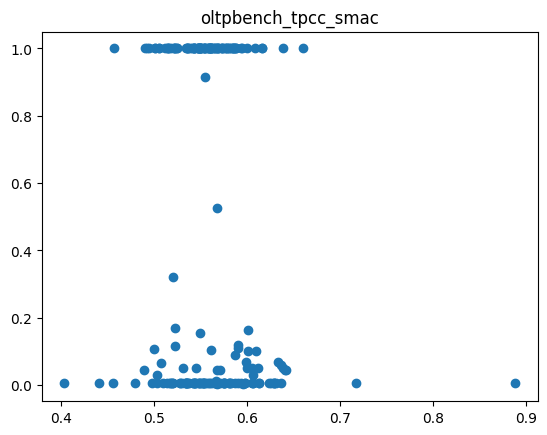

In [ ]:
workload = "oltpbench_tpcc_smac"
similarity_list = [0.561175, 0.519625, 0.56755, 0.590175, 0.577975, 0.640925, 0.659625, 0.40332500000000004, 0.5986, 0.5807, 0.51815, 0.6412249999999999, 0.559275, 0.5507, 0.5936250000000001, 0.5787249999999999, 0.49444999999999995, 0.547375, 0.5033000000000001, 0.542575, 0.61225, 0.5246999999999999, 0.5592250000000001, 0.5352, 0.623625, 0.5884750000000001, 0.56065, 0.55775, 0.568575, 0.5689, 0.567475, 0.566225, 0.53405, 0.6052, 0.51755, 0.5822, 0.547675, 0.6111249999999999, 0.625575, 0.565725, 0.586125, 0.6066, 0.6056250000000001, 0.51925, 0.520125, 0.54375, 0.574925, 0.553925, 0.552225, 0.567825, 0.6093, 0.5546, 0.573175, 0.51625, 0.5863, 0.5533, 0.4407, 0.49265000000000003, 0.62915, 0.54435, 0.5605249999999999, 0.5725750000000001, 0.48985, 0.5904499999999999, 0.580775, 0.5669500000000001, 0.50515, 0.5488500000000001, 0.6161, 0.5749, 0.6080749999999999, 0.583575, 0.606325, 0.5281, 0.543025, 0.5492250000000001, 0.5222249999999999, 0.6065, 0.554125, 0.6293500000000001, 0.534775, 0.5001, 0.5379499999999999, 0.522275, 0.5504249999999999, 0.639, 0.5494, 0.489375, 0.5427500000000001, 0.571025, 0.6288750000000001, 0.5057, 0.52195, 0.5899, 0.56035, 0.49817500000000003, 0.502525, 0.501225, 0.575975, 0.55645, 0.5977250000000001, 0.5676749999999999, 0.580625, 0.536225, 0.584975, 0.521625, 0.59945, 0.550125, 0.5474749999999999, 0.632675, 0.538825, 0.6009, 0.53445, 0.5447, 0.551425, 0.5867249999999999, 0.6381, 0.536475, 0.549125, 0.54815, 0.51435, 0.5070749999999999, 0.515075, 0.570975, 0.888175, 0.534875, 0.5608500000000001, 0.543525, 0.47967499999999996, 0.575875, 0.59495, 0.564875, 0.4569, 0.5690500000000001, 0.59945, 0.5488, 0.593275, 0.554825, 0.631, 0.536475, 0.5353, 0.51405, 0.5883, 0.556875, 0.54345, 0.5429999999999999, 0.5116499999999999, 0.517225, 0.534275, 0.5475749999999999, 0.5846, 0.540925, 0.582875, 0.5211, 0.5224249999999999, 0.5304, 0.5279750000000001, 0.5776749999999999, 0.63645, 0.56065, 0.5306500000000001, 0.5816749999999999, 0.565975, 0.5417000000000001, 0.5717749999999999, 0.612725, 0.5332749999999999, 0.5682, 0.552825, 0.5478000000000001, 0.50075, 0.60135, 0.50985, 0.455375, 0.514, 0.587125, 0.574325, 0.5246999999999999, 0.5197499999999999, 0.5419499999999999, 0.562425, 0.534275, 0.559775, 0.5634, 0.5532, 0.5808, 0.56545, 0.559275, 0.58725, 0.5475749999999999, 0.5419499999999999, 0.6366, 0.5656749999999999, 0.5978749999999999, 0.5741499999999999, 0.554575, 0.575225, 0.6159250000000001, 0.56275, 0.55375, 0.55855, 0.59545, 0.55375, 0.5494, 0.5608, 0.547025, 0.717525]
ranks = [0.1044776119402985, 0.004975124378109453, 0.003105590062111801, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5247395833333334, 0.010638297872340425, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.029850746268656716, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.09950248756218906, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.11940298507462686, 1.0, 1.0, 1.0, 0.15422885572139303, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.11442786069651742, 0.004975124378109453, 0.9152542372881356, 0.004975124378109453, 1.0, 0.1065989847715736, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.17069486404833836, 0.10945273631840796, 1.0, 0.004975124378109453, 0.029850746268656716, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.04477611940298507, 1.0, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 1.0, 1.0, 0.06965174129353234, 1.0, 0.09950248756218906, 0.004975124378109453, 0.04975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.06467661691542288, 1.0, 0.04477611940298507, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.05970149253731343, 1.0, 0.04950495049504951, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.16417910447761194, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.08955223880597014, 1.0, 1.0, 0.3215077605321508, 1.0, 0.004975124378109453, 0.004975124378109453, 0.005076142131979695, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.0014184397163120568, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

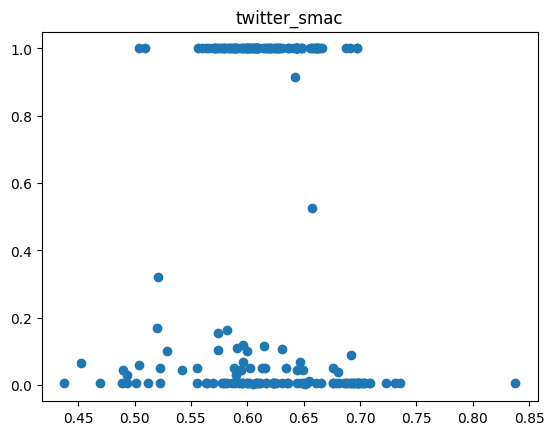

In [ ]:
workload = "twitter_smac"
similarity_list = [0.57365, 0.49312500000000004, 0.6050249999999999, 0.62525, 0.5807, 0.59485, 0.56, 0.6227, 0.596325, 0.6879, 0.6139, 0.5949, 0.6597, 0.691025, 0.563725, 0.618225, 0.6576, 0.8377, 0.7038249999999999, 0.6304000000000001, 0.6106750000000001, 0.590025, 0.48875, 0.596125, 0.665375, 0.569825, 0.697025, 0.619775, 0.6218250000000001, 0.58885, 0.65735, 0.6552, 0.565875, 0.676275, 0.594225, 0.6060749999999999, 0.571075, 0.58865, 0.616425, 0.578675, 0.5997250000000001, 0.5898749999999999, 0.6757500000000001, 0.5888, 0.649475, 0.6019749999999999, 0.703925, 0.60015, 0.6803250000000001, 0.607325, 0.528775, 0.601375, 0.556575, 0.6043499999999999, 0.6286499999999999, 0.5865750000000001, 0.5124, 0.57175, 0.5694250000000001, 0.6984, 0.6090249999999999, 0.662525, 0.5876250000000001, 0.596625, 0.63685, 0.6428499999999999, 0.6647000000000001, 0.573925, 0.587425, 0.64425, 0.5957, 0.64895, 0.5780000000000001, 0.6241749999999999, 0.6199749999999999, 0.6930499999999999, 0.6146750000000001, 0.5009250000000001, 0.6423749999999999, 0.43767500000000004, 0.589, 0.6308750000000001, 0.6899500000000001, 0.64435, 0.65745, 0.5731999999999999, 0.6258250000000001, 0.49015, 0.609225, 0.522375, 0.647675, 0.64445, 0.519525, 0.59095, 0.582525, 0.600075, 0.4931, 0.60835, 0.6228750000000001, 0.6626000000000001, 0.6984, 0.542125, 0.6278250000000001, 0.6438999999999999, 0.6153500000000001, 0.6078749999999999, 0.5224, 0.68725, 0.59375, 0.6469, 0.5991500000000001, 0.5998, 0.634675, 0.602075, 0.7232000000000001, 0.64365, 0.5552, 0.61625, 0.5964499999999999, 0.608475, 0.60495, 0.452875, 0.61905, 0.64925, 0.46935000000000004, 0.5844750000000001, 0.6077, 0.6949000000000001, 0.58065, 0.56385, 0.5804750000000001, 0.6099749999999999, 0.5089250000000001, 0.62385, 0.570975, 0.7013, 0.665975, 0.640625, 0.595375, 0.598975, 0.6920999999999999, 0.662175, 0.626, 0.708325, 0.592625, 0.697025, 0.6278, 0.63565, 0.5823, 0.6441250000000001, 0.591275, 0.5965750000000001, 0.60795, 0.5041, 0.575325, 0.67875, 0.651625, 0.655675, 0.504, 0.697025, 0.6133, 0.6994750000000001, 0.6946749999999999, 0.6236999999999999, 0.588275, 0.615525, 0.6167, 0.7032499999999999, 0.69755, 0.661225, 0.6434, 0.5817, 0.66135, 0.6011500000000001, 0.6760999999999999, 0.6919, 0.584275, 0.64375, 0.5211250000000001, 0.60355, 0.68805, 0.5552250000000001, 0.599575, 0.6480250000000001, 0.6855249999999999, 0.636425, 0.6075999999999999, 0.6597, 0.564125, 0.6441250000000001, 0.68165, 0.6534, 0.611625, 0.5791, 0.6307499999999999, 0.7358, 0.709275, 0.5767249999999999, 0.6473, 0.5783499999999999, 0.6017, 0.65115, 0.64335, 0.6258250000000001, 0.636075, 0.608375, 0.731125]
ranks = [0.1044776119402985, 0.004975124378109453, 0.003105590062111801, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.06965174129353234, 0.004975124378109453, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5247395833333334, 0.010638297872340425, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 0.004975124378109453, 1.0, 1.0, 0.029850746268656716, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.03980099502487562, 1.0, 0.09950248756218906, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.11940298507462686, 1.0, 1.0, 1.0, 0.15422885572139303, 1.0, 0.04477611940298507, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.11442786069651742, 0.004975124378109453, 0.9152542372881356, 0.004975124378109453, 1.0, 0.1065989847715736, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.04477611940298507, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.17069486404833836, 0.10945273631840796, 1.0, 0.004975124378109453, 0.029850746268656716, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.04477611940298507, 1.0, 0.004975124378109453, 1.0, 1.0, 0.04975124378109453, 1.0, 1.0, 0.06965174129353234, 1.0, 0.09950248756218906, 0.04975124378109453, 0.04975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.06467661691542288, 1.0, 0.04477611940298507, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 0.004975124378109453, 1.0, 1.0, 0.004975124378109453, 0.004975124378109453, 1.0, 0.05970149253731343, 1.0, 0.04950495049504951, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.04975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 0.16417910447761194, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.08955223880597014, 1.0, 1.0, 0.3215077605321508, 1.0, 0.004975124378109453, 0.004975124378109453, 0.005076142131979695, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 0.004975124378109453, 1.0, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 1.0, 1.0, 1.0, 1.0, 0.0014184397163120568, 1.0, 1.0, 1.0, 1.0, 0.004975124378109453]
plt.scatter(similarity_list, ranks)
plt.title(workload)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

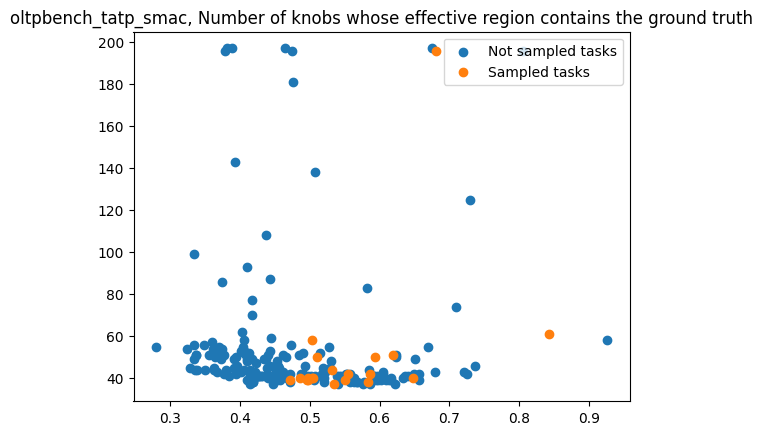

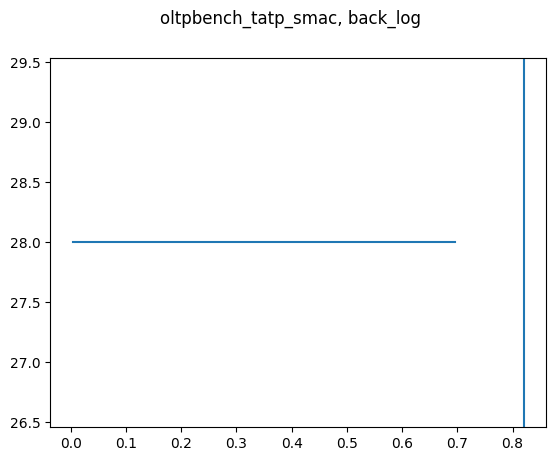

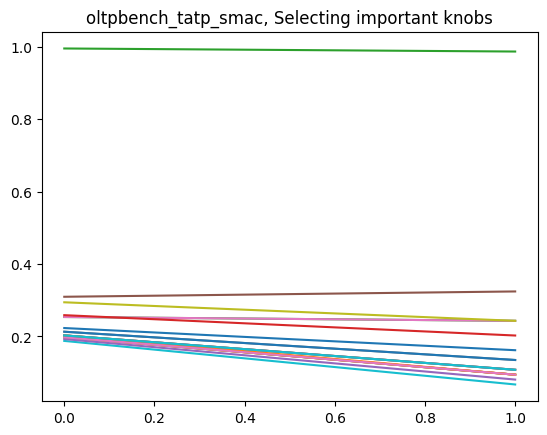

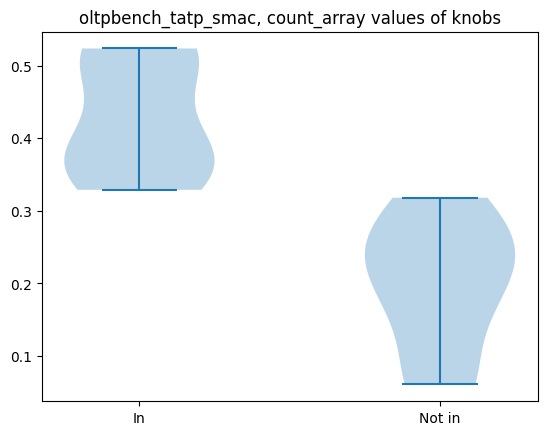

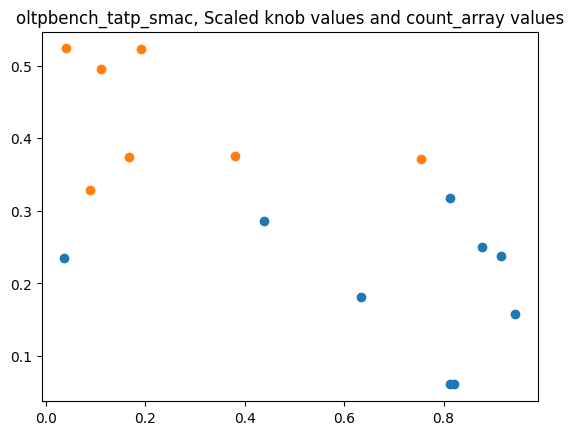

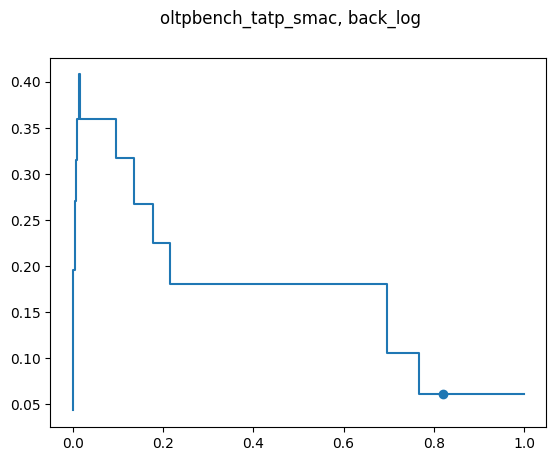

In [ ]:


plt.scatter(not_sampled_similarities, not_sampled_spaces, label="Not sampled tasks")
plt.scatter(sampled_similarities, sampled_spaces, label="Sampled tasks")
plt.title(f"{workload}, Number of knobs whose effective region contains the ground truth")
plt.legend()
plt.show()

for k in effective_regions_x:
    plt.plot(effective_regions_x[k],effective_regions_y[k])
    plt.axvline(x=vectors[k])
    plt.suptitle(f"{workload}, {k}")
    plt.show()
    break

a=np.transpose([sampled_spaces_scaled,sampled_important_spaces])
for i in range(a.shape[0]):
    plt.plot(a[i])
plt.title(f"{workload}, Selecting important knobs")
plt.show()

plt.violinplot([ground_truth_in_target_range, ground_truth_not_in_target_range])
plt.xticks([1, 2], labels=["In", "Not in"])
plt.title(f"{workload}, count_array values of knobs")
plt.show()

plt.scatter(vectors_not_in_ground_truth,ground_truth_not_in_target_range)
plt.scatter(vectors_in_ground_truth,ground_truth_in_target_range)
plt.title(f"{workload}, Scaled knob values and count_array values")
plt.show()

for k in vectors:
    x=[]
    y=[]
    v=count_arrays2[k]
    for vv in v:
        x.append(vv[0])        
        x.append(vv[1])
        y.append(vv[2])
        y.append(vv[2])
    plt.plot(x,y)
    plt.scatter([vectors[k]],[count_arrays[k]])
    plt.suptitle(f"{workload}, {k}")
    plt.show()
    break

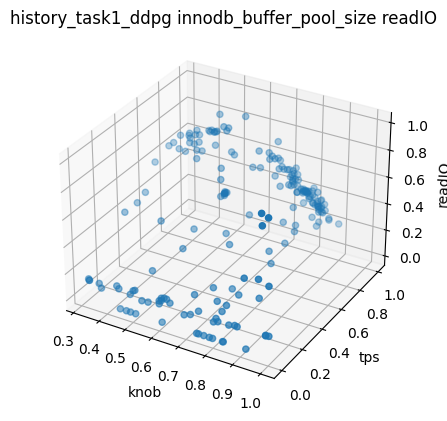

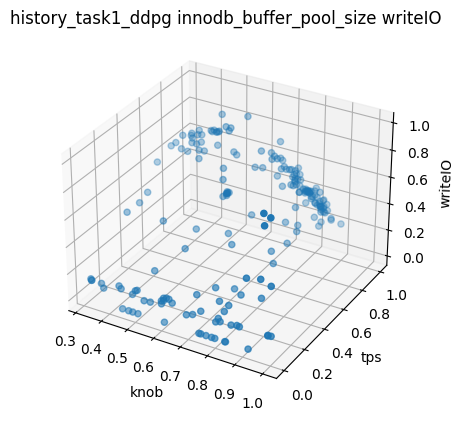

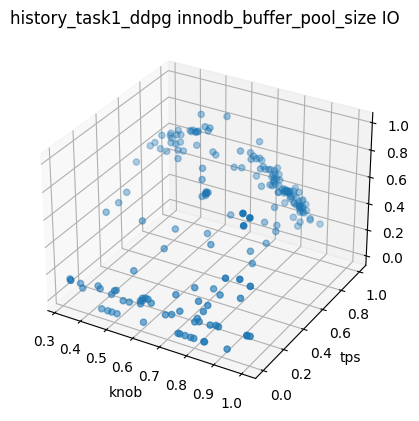

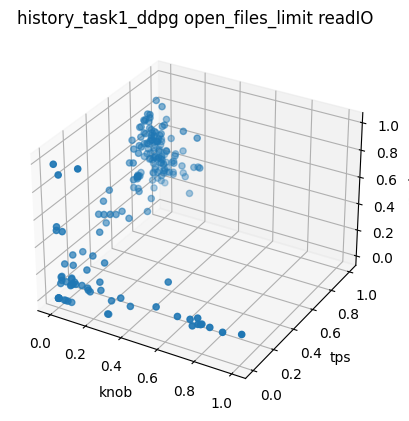

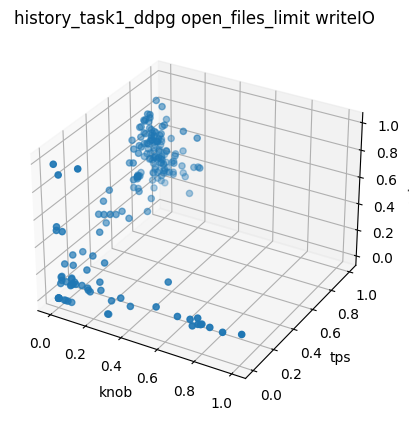

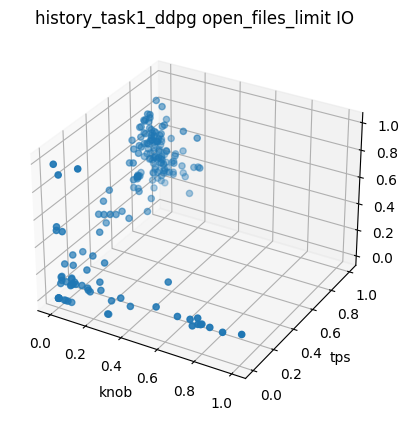

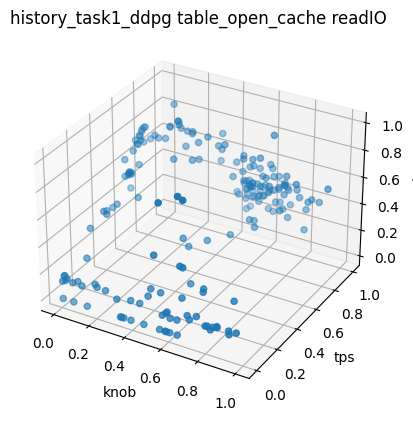

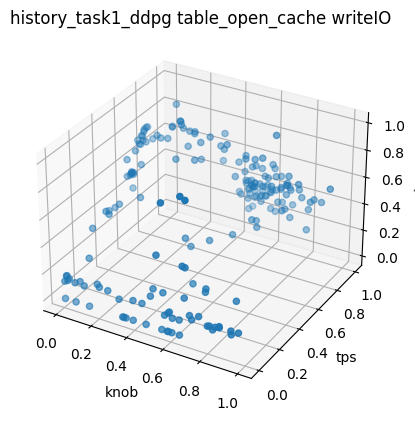

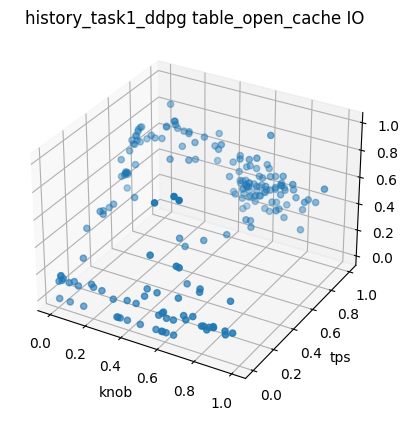

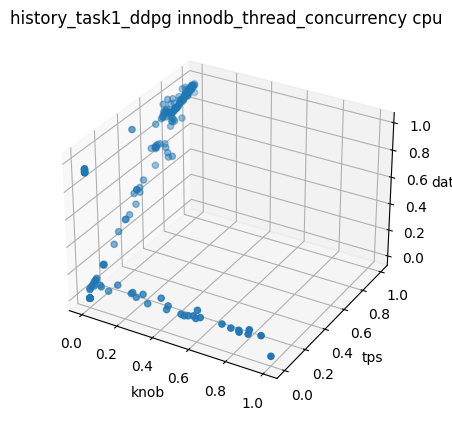

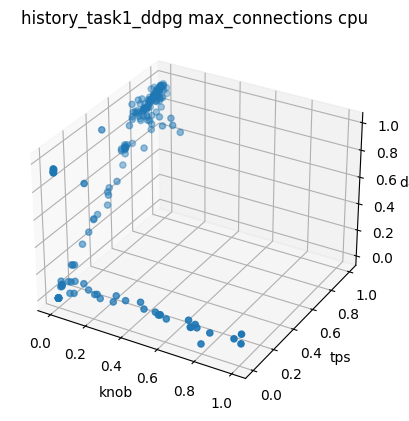

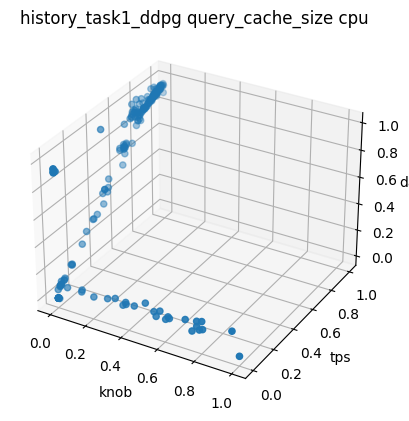

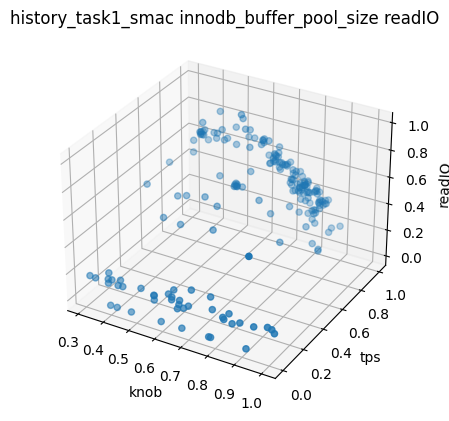

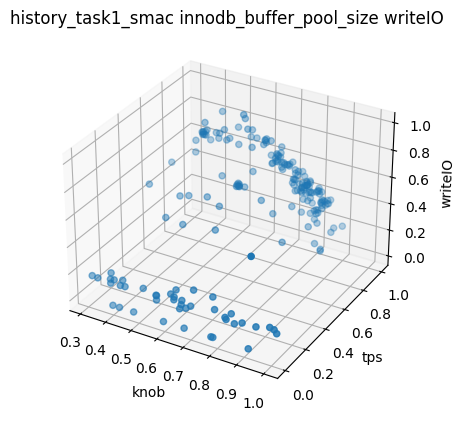

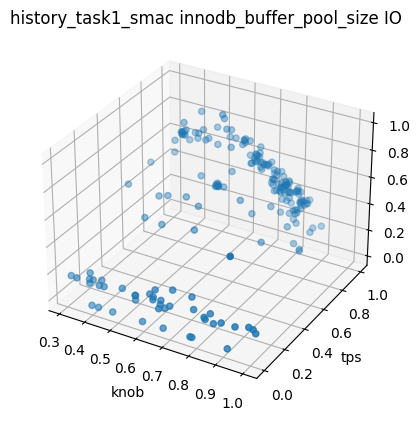

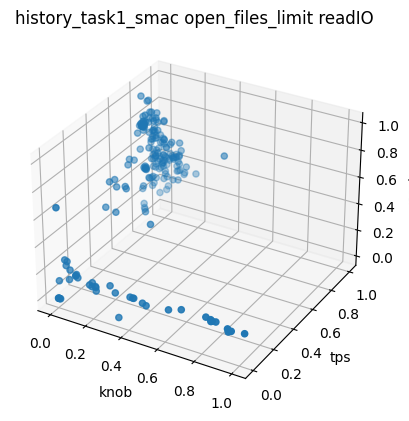

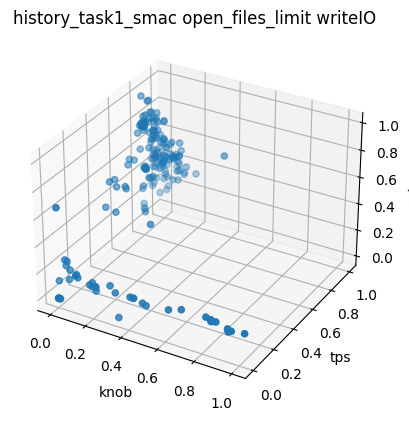

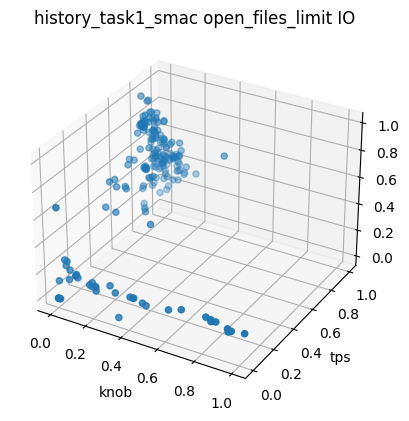

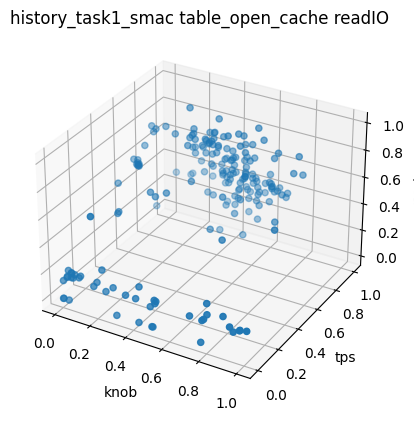

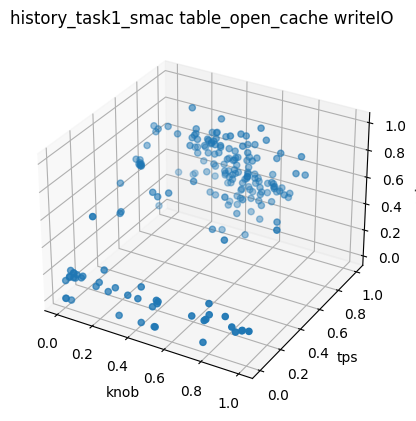

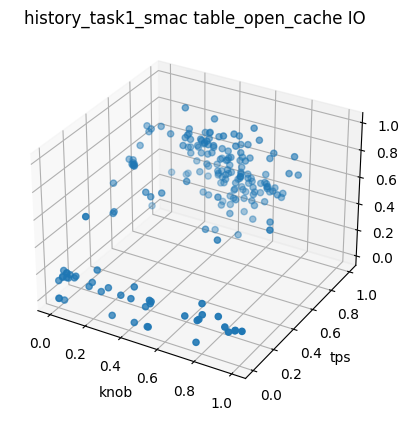

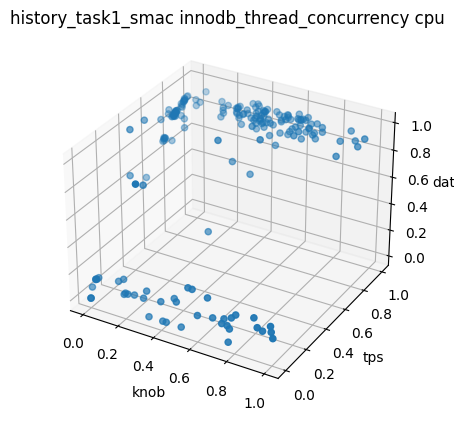

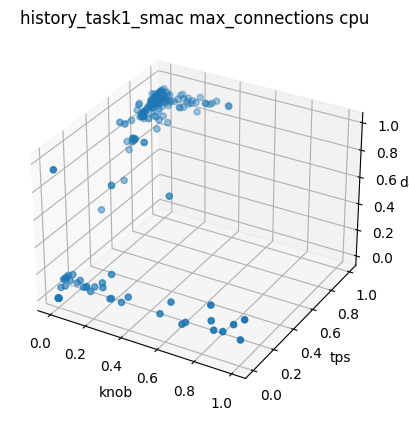

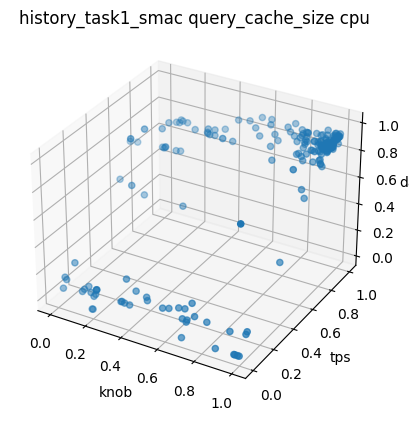

In [ ]:
import pprint
import re
from typing import List
from matplotlib import pyplot as plt
import json
import numpy as np


class Hyperparameter:
    def __init__(
        self, name: str, param_type: str, param_range: List[int], default: int
    ):
        self.name = name
        self.param_type = param_type
        self.param_range = param_range
        self.default = default

    def __repr__(self) -> str:
        return (
            f"Hyperparameter(name='{self.name}', type='{self.param_type}', "
            f"range={self.param_range}, default={self.default})"
        )


CONFIG_BLOCK_PATTERN = re.compile(
    r"Configuration space object:\s*"
    r"Hyperparameters:(.*?)(?=Configuration space object:|$)",
    re.DOTALL,  # Enables matching across multiple lines
)
HYPERPARAMETER_PATTERN = re.compile(
    r"\s*(\w+), Type: (\w+), Range: \[(\d+), (\d+)\], Default: (\d+)"
)
for workload in [
    "history_task1_ddpg",
    "history_task1_smac",
]:
    with open(f"/root/OpAdviserPrivate/repo/{workload}.json") as f:
        data = json.load(f)["data"]
        tps = np.array(list(map(lambda x: x["external_metrics"].get("tps", 0), data)))
        tps = tps / max(tps)
        for knob in [
            "innodb_buffer_pool_size",
            # "innodb_change_buffering",
            "key_buffer_size",
            "innodb_io_capacity",
            "innodb_io_capacity_max",
            # "innodb_flush_log_at_trx_commit",
            "sync_binlog",
            # "innodb_doublewrite",
            # "innodb_file_per_table",
            "open_files_limit",
            "table_open_cache",
        ]:
            if knob not in data[0]["configuration"]:
                continue
            knobs = np.array(list(map(lambda x: x["configuration"][knob], data)))
            knobs = knobs / max(knobs)

            readIO = np.array(list(map(lambda x: x["resource"].get("readIO", 0), data)))
            fig = plt.figure()
            ax = fig.add_subplot(projection="3d")
            ax.scatter(knobs, tps, readIO / max(readIO), label="readIO")
            ax.set_xlabel("knob")
            ax.set_ylabel("tps")
            ax.set_zlabel("readIO")
            plt.title(f"{workload} {knob} readIO")
            plt.show()

            writeIO = np.array(
                list(map(lambda x: x["resource"].get("writeIO", 0), data))
            )
            fig = plt.figure()
            ax = fig.add_subplot(projection="3d")
            ax.scatter(knobs, tps, readIO / max(readIO), label="writeIO")
            ax.set_xlabel("knob")
            ax.set_ylabel("tps")
            ax.set_zlabel("writeIO")
            plt.title(f"{workload} {knob} writeIO")
            plt.show()

            IO = np.array(list(map(lambda x: x["resource"].get("IO", 0), data)))
            fig = plt.figure()
            ax = fig.add_subplot(projection="3d")
            ax.scatter(knobs, tps, readIO / max(readIO), label="IO")
            ax.set_xlabel("knob")
            ax.set_ylabel("tps")
            ax.set_zlabel("IO")
            plt.title(f"{workload} {knob} IO")
            plt.show()
        for knob in [
            "innodb_thread_concurrency",
            "thread_cache_size",
            "max_connections",
            "query_cache_size",
            "sort_buffer_size",
            "join_buffer_size",
            "tmp_table_size",
            "innodb_purge_threads",
            "innodb_read_io_threads",
            "innodb_write_io_threads",
            "optimizer_search_depth",
            # "optimizer_prune_level",
        ]:
            if knob not in data[0]["configuration"]:
                continue
            knobs = np.array(list(map(lambda x: x["configuration"][knob], data)))
            knobs = knobs / max(knobs)
            cpu = np.array(list(map(lambda x: x["resource"].get("cpu", 0), data)))
            fig = plt.figure()
            ax = fig.add_subplot(projection="3d")
            ax.scatter(knobs, tps, cpu / max(cpu), label="data")
            ax.set_xlabel("knob")
            ax.set_ylabel("tps")
            ax.set_zlabel("data")
            plt.title(f"{workload} {knob} cpu")
            plt.show()
    # with open(
    #     f"scripts/experiment/gen_knobs/mysql_all_197_32G.json"
    # ) as f:
    #     j = json.load(f)
    # with open(f"/workspaces/OpAdviserPrivate/logs/DBTune-{workload}_smac.log") as f:
    #     config_text = f.read()
    #     config_blocks = CONFIG_BLOCK_PATTERN.findall(config_text)
    #     contains = []
    #     sizes = []
    #     for block in config_blocks:
    #         hyperparameters = []
    #         containing = []
    #         size = []
    #         for match in HYPERPARAMETER_PATTERN.findall(block):
    #             name, param_type, range_start, range_end, default = match
    #             if param_type != "UniformInteger":
    #                 pprint.pprint(param_type)
    #             if int(range_start) <= c[name] <= int(range_end):
    #                 containing.append(1)
    #             else:
    #                 containing.append(0)
    #             hyperparameters.append(
    #                 Hyperparameter(
    #                     name=name,
    #                     param_type=param_type,
    #                     param_range=[int(range_start), int(range_end)],
    #                     default=int(default),
    #                 )
    #             )
    #             size.append(
    #                 (int(range_end) - int(range_start))
    #                 / (j[name]["max"] - j[name]["min"])
    #             )
    #         contains.append(sum(containing) / len(containing))
    #         sizes.append(sum(size) / len(size))

In [63]:
import pandas as pd
import os

df = pd.DataFrame(
    columns=[
        "filename",
        "tps",
        # cpu
        "innodb_thread_concurrency",
        "thread_cache_size",
        "max_connections",
        "query_cache_size",
        "sort_buffer_size",
        "join_buffer_size",
        "tmp_table_size",
        "innodb_purge_threads",
        "innodb_read_io_threads",
        "innodb_write_io_threads",
        "optimizer_search_depth",
        # "optimizer_prune_level",#categorical variable
        "cpu",
        # IO
        "innodb_buffer_pool_size",
        # "innodb_change_buffering",#categorical variable
        "key_buffer_size",
        "innodb_io_capacity",
        "innodb_io_capacity_max",
        # "innodb_flush_log_at_trx_commit",#categorical variable
        "sync_binlog",
        # "innodb_doublewrite",#categorical variable
        # "innodb_file_per_table",#categorical variable
        "open_files_limit",
        "table_open_cache",
        "readIO",
        "writeIO",
        "IO",
    ]
)
path = "/root/OpAdviserPrivate/repo"
for filename in os.listdir(path):
    filepath = os.path.join(path, filename)
    if not os.path.isfile(filepath):
        continue
    with open(filepath) as f:
        data = pd.DataFrame(json.load(f)["data"]).sort_values(
            "external_metrics", key=lambda x: x.apply(lambda y: y.get("tps", 0))
        )
        data = data.iloc[-1]
        configuration = pd.DataFrame(data["configuration"], index=[0])

        # Create a new row with all columns initialized to None/NaN
        new_row = pd.Series(index=df.columns, dtype=object)

        # Fill in configuration values
        common_columns = df.columns.intersection(configuration.columns)
        new_row[common_columns] = configuration[common_columns].iloc[0]

        # Fill in the additional columns
        new_row["filename"] = filename
        new_row["tps"] = data["external_metrics"]["tps"]
        new_row["cpu"] = data["resource"]["cpu"]
        new_row["readIO"] = data["resource"]["readIO"]
        new_row["writeIO"] = data["resource"]["writeIO"]
        new_row["IO"] = data["resource"]["IO"]

        # Add the new row to the DataFrame
        df.loc[len(df)] = new_row
df.to_csv("csv.csv", index=False)